# Automatic classification of eclipsing binary stars using deep learning methods

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)

# from noise_generator import stochastic_noise_generator
# from curve_alignement import curve_alignement_randomizer
from sklearn.model_selection import train_test_split


from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import scikitplot as skplt

In [2]:
# V pripade ak boli chyby s importami, tak je potrebne to spustit (robi sa so zdielanymi prostrediami)

# %pip install keras
# %pip install elisa
# %pip install imblearn
# %pip install --upgrade tensorflow
# %pip install --upgrade tensorflow-gpu
# %pip install scikit-plot

## Data load

- load observed light curve 


In [6]:
data = pd.read_csv("out.csv",usecols = ['filename','Type','curve'] )

data.columns = ["name", "curve", "Type"]
data.head(20)

,name,curve,Type
0,229942225_LC_0,"[0.9873266526590195, 0.9867239891795271, 0.986...",1
1,229942225_LC_1,"[0.9936944466554205, 0.9932286506948224, 0.992...",1
2,229942225_LC_2,"[0.9539541336221352, 0.9530162556644028, 0.952...",1
3,229942225_LC_3,"[0.9473314127381565, 0.9482792706338509, 0.949...",1
4,229942225_LC_4,"[0.9981291473698083, 0.9976810473290275, 0.997...",1
5,229942225_LC_5,"[0.9573077736980483, 0.9580415101965923, 0.958...",1
6,229942225_LC_6,"[0.9765339251538715, 0.9775631331040816, 0.978...",1
7,229942225_LC_7,"[0.9396687971917272, 0.9395903048847896, 0.939...",1
8,229942225_LC_8,"[0.9623555985880528, 0.9632869681133504, 0.964...",1
9,229942225_LC_9,"[0.9507700638112141, 0.9517024542446126, 0.952...",1


In [7]:
# data = data.replace(to_replace='overcontact', value=1)
# data = data.replace(to_replace='detached', value=0)
# data

### Check data 

In [9]:
data.dtypes

name     object
curve    object
Type      int64
dtype: object

In [10]:
data['Type'].value_counts()

1    60
0    60
Name: Type, dtype: int64

## Data preparation
- bessel_to_array 

In [11]:
def bessel_to_array(column_name, df):
    """Model expects array input. 
    This function transforms all curves in 1 column (400 comma seperated numbers) to array"""
    newData_bessell = []
    for row in df[column_name]:
        if pd.isna(row):
            print(row,"df")
            continue
        newRow = []
        letter_list = row.split(",")
        for number in letter_list:
            number = number.replace(']', '')
            number = number.replace('[', '')
            newRow.append(float(number))
        newData_bessell.append(newRow) 
    newData_bessell = np.array(newData_bessell)
    print(newData_bessell)
    return newData_bessell

In [12]:
X_train_with_arrays_noise = []
for column in ['curve']:
    X_train_with_arrays_noise.append(bessel_to_array(column, data))
    print(column + " " + "prossessed")

[[0.98732665 0.98672399 0.98615178 ... 0.98808133 0.98758401 0.98705912]
 [0.99369445 0.99322865 0.99272308 ... 0.99513033 0.99463045 0.99417957]
 [0.95395413 0.95301626 0.95214745 ... 0.95551448 0.95453641 0.95356323]
 ...
 [0.98564398 0.98552313 0.98549019 ... 0.98556036 0.98547957 0.98536397]
 [0.99825239 0.99849669 0.99868945 ... 0.99819745 0.99846433 0.99879236]
 [0.98992434 0.98968115 0.98946703 ... 0.99056133 0.99046112 0.9903674 ]]
curve prossessed


In [13]:
# (5, 2, 16000, 400, 1) -> meaning: 
# 5 - UBVRI
# 16000 - number of curves
# 400 - size of 1 curve
# 1 - detached or overcontact

print(np.array(X_train_with_arrays_noise).shape)


(1, 120, 400)


In [14]:
# target is overcontact
target = np.array(data['Type'])
print(target)

# just to be sure that both types are in dataset
exists = 0 in target
print(exists)
exists = 1 in target
print(exists)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
True
True


> Control the shape and check if the dataset is imbalanced (ale nacital som si z oboch 10 000 cize viem ze by mal byt vyvazeny)

In [15]:
print(target.shape)
print(Counter(target))

(120,)
Counter({1: 60, 0: 60})


    - fit and apply the transform

In [16]:
def print_shape_counter(column, target):
    print(column.shape)
    print(target.shape)
    print(Counter(target))

In [17]:
for i in range(1):
    print_shape_counter(X_train_with_arrays_noise[i], data['Type'])
    print("")

(120, 400)
(120,)
Counter({1: 60, 0: 60})



# Model Observed evaluation

In [18]:
def evaluate_all(model_path, input_data, y_test):
    classifier = load_model(model_path)
    # y_pred returns probability of detached and overcontact 
    # for example [1.4059671e-04, 9.9985933e-01], 
    # means detached with prob. 0.0001405  and overcontact with prob 0.998
    y_pred = classifier.predict(input_data)
    # print(y_pred)
    
    # for example [1.4059671e-04, 9.9985933e-01] -> [0, 1], it is marked as detached 
    y_pred2 = np.where(y_pred > 0.4, 1, 0)
    
    # test data [0,1,...] is converted to categorical [[0,1],[1,0]]
    target_test = np.array(y_test)
    target_test = np_utils.to_categorical(target_test, 2)
    
    # confusion matrix -old 
    # cm = confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    # print("Confusion matrix: \n" + str(cm))
    
    # confusion matrix - nice print 
    matrix=skplt.metrics.plot_confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    matrix.xaxis.set_ticklabels(['single_spotty', 'binary_star'])
    matrix.yaxis.set_ticklabels(['single_spotty', 'binary_star'])
    matrix
    
    target_names= ['single_spotty', 'binary_star']
    print("Classification report: \n" + classification_report(target_test.argmax(axis=1), y_pred2.argmax(axis=1),target_names=target_names))
    # from categorical [0, 1] -> 1
    y_true = target_test.argmax(axis=1)
    
    skplt.metrics.plot_roc(y_true, y_pred)
    plt.savefig('roc_auc.png')
    plt.show()
    
    input_data = np.array(input_data)
    y_test2=data[['name', 'Type']]

    
#     limit_plot=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 1) and (target_test[j].argmax(axis=0) == 0):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test2.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
#                 plt.suptitle("Malo byt 0(detached) ale urcilo ako 1(overcontact)")
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single_spotty 0", ha="center", va="bottom", color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "binary_star 1", ha="center", va="bottom",  color="red")
#                 limit_plot=limit_plot+1
            else:
                plt.plot(input_data[j],label = str(y_test2.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
#                 plt.suptitle("Malo byt 0(detached) ale urcilo ako 1(overcontact)")
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single_spotty 0", ha="center", va="bottom" ,color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62,0.9, "binary_star 1", ha="center", va="bottom",  color="red")
#             if limit_plot == 2:
#                 break 

    
    plt.legend(loc='upper right')       
    plt.savefig('image.png')
    plt.show()     

## KED CHCEM VSETKY 
#     for j in range(len(y_pred2)):
# KED CHCEM IBA 7
#     limit_plot2=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 0) and (target_test[j].argmax(axis=0) == 1):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(data.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single_spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "binary_star 1", ha="center", va="bottom",  color="green")
#                 plt.title("Malo byt 1(overcontact) ale urcilo ako 0(detached)")
#                 limit_plot2=limit_plot2+1
            else:
                plt.plot(input_data[j],label = str(data.iloc[[j]].name) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single_spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "binary_star 1", ha="center", va="bottom",  color="green")
#                 plt.title("Malo byt 1(overcontact) ale urcilo ako 0(detached)")
#                 limit_plot2=limit_plot2+1
#             if limit_plot2 == 2:
#                 break 
    
    plt.legend(loc='upper right')       
    plt.savefig('image2.png')
    plt.show()
    
   
    print(y_test2)

(120,)
(120, 400)
Classification report: 
               precision    recall  f1-score   support

single_spotty       0.55      0.88      0.68        60
  binary_star       0.71      0.28      0.40        60

     accuracy                           0.58       120
    macro avg       0.63      0.58      0.54       120
 weighted avg       0.63      0.58      0.54       120



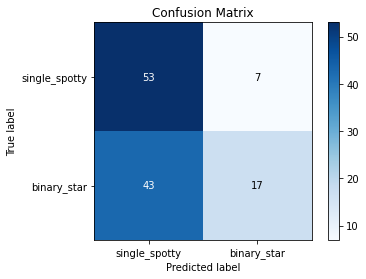

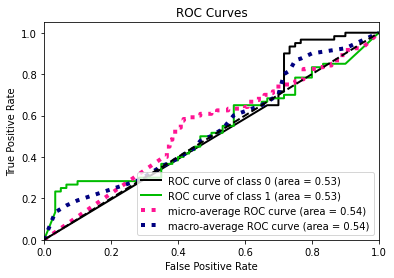

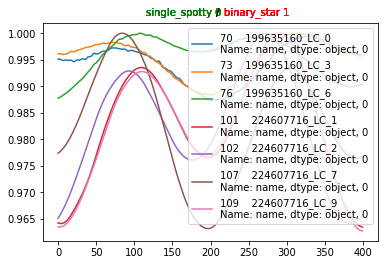

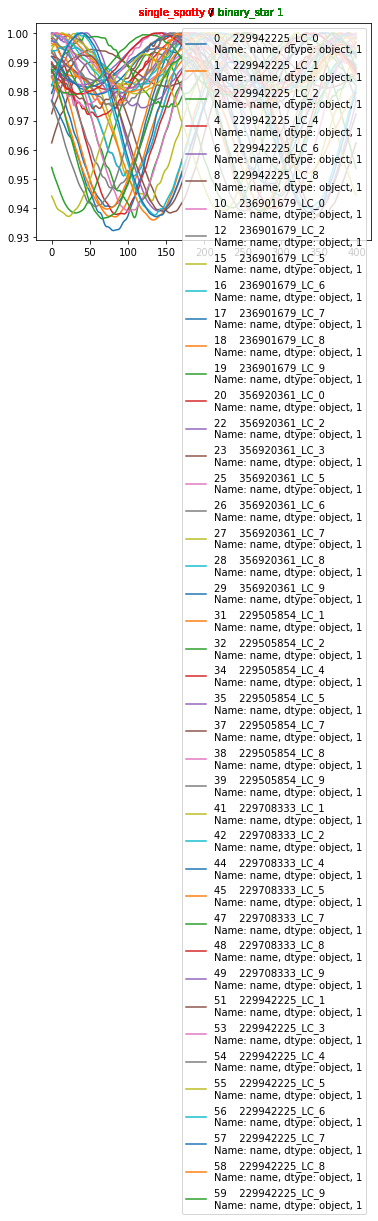

               name  Type
0    229942225_LC_0     1
1    229942225_LC_1     1
2    229942225_LC_2     1
3    229942225_LC_3     1
4    229942225_LC_4     1
..              ...   ...
115  229464312_LC_5     0
116  229464312_LC_6     0
117  229464312_LC_7     0
118  229464312_LC_8     0
119  229464312_LC_9     0

[120 rows x 2 columns]


In [19]:
processed_test_data= X_train_with_arrays_noise[0]

y_test_mixed = data['Type']

print(y_test_mixed.shape)
print(processed_test_data.shape)

evaluate_all('model_single_spotty_binary.hdf5', processed_test_data, y_test_mixed)